## Face Recognition Evaluation 

The provided pipeline evaluates the performance of a face recognition system based on the Inception Resnet (V1) model, pre-trained on VGGFace2 and CASIA-Webface datasets. The goal of the evaluation is to assess the accuracy of the model on unseen data, particularly the Labeled Faces in the Wild (LFW) dataset, which the model has not been trained on.

The system is composed of three key modules, applied in a cascading fashion:

**1. Face Detection (MTCNN)**: 
the MTCNN (Multi-task Cascaded Convolutional Networks) is used to detect faces within images. It localizes the bounding box around the face and crops the image accordingly, ensuring that a margin (set to 14 pixels) is added to capture the entire face. 

**2. Anti-Spoofing Module:** 
after cropping the face, an anti-spoofing module checks whether the detected face is genuine or a spoof (e.g., printed photo, video replay). This is crucial to prevent false matches from imposters using fake images or videos.

**3. Face Recognition (Inception Resnet V1):** 
if the face is detected and validated as real, the face recognition model proceeds. This model is used to compare the face (the probe) declared with the templates saved in the gallery that are associated with the declared identity and computes a matching score based on the extracted facial features, represented as embeddings. These embeddings are vectors that capture the distinct features of each face.


To ensure a comprehensive evaluation, the model (once pre-trained on VGGFace2 once on CASIA-Webface) was tested on subsets of the LFW dataset under various experimental conditions. The subsets were defined based on the number of templates (images) available for each identity, with experiments conducted for S = 2, 3, 9, 70 templates per identity.

For each subset, the system computed an ALL-against-ALL distance matrix between the embeddings of the selected images. The matrix contained the Euclidean distances between every pair of embeddings (without considering the pairs along the main diagonal), with each row representing a probe image and each column representing a template from the gallery. To enhance performance, the distances were normalized using min-max normalization, ensuring the values ranged from 0 to 1.

The following metrics were used to evaluate the face recognition system:

* **GA (Genuine Acceptance)**: the number of times the system correctly identifies two images as the same person.
* **FA (False Acceptance)**: the number of times the system incorrectly identifies two different people as the same person.
* **FR (False Rejection)**: the number of times the system incorrectly identifies two images of the same person as different people.
* **GR (Genuine Rejection)**: the number of times the system correctly identifies two different people as different.

Using these counts, the following metrics were calculated: 

* **GAR (Genuine Acceptance Rate)**: the percentage of correct matches (when the system correctly identifies a person).
* **FAR (False Acceptance Rate)**: the percentage of wrong matches (when the system mistakenly matches different people). 
* **FRR (False Rejection Rate)**: the percentage of failed matches (when the system fails to match the same person).
* **GRR (Genuine Rejection Rate)**: the percentage of correct rejections (when the system correctly identifies different people as different). 

The ROC (Receiver Operating Characteristic), the DET (Detection Error Tradeoff) curves and the EER (Equal Error Rate) are computed.

## Preprocessing and utils definition

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, transforms
import numpy as np
import os
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings
from torchsummary import summary
from tqdm import tqdm

In [2]:
data_dir = r'C:\Users\Asus\Desktop\Biometric Systems\Datasets\lfw\raw'

batch_size = 16
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

warnings.filterwarnings("ignore")  # Suppress all warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Running on device: cuda:0


In [3]:
# Initializes the MTCNN (Multi-task Cascaded Convolutional Networks) 
mtcnn = MTCNN(
    image_size=224, # Set image size to 224x224 pixels
    margin=14, # Add a margin of 14 pixels around the detected face
    device=device, # Processes images on the specified device (CPU or GPU)
    selection_method='center_weighted_size' # Use center-weighted size for face selection

In [4]:
# Define the data loader for the input set of images
orig_img_ds = datasets.ImageFolder(data_dir, transform=None)

In [5]:
# overwrites class labels in dataset with path so path can be used for saving output in mtcnn batches
orig_img_ds.samples = [
    (p, p)
    for p, _ in orig_img_ds.samples
]

In [8]:
# Create a DataLoader for the input images with multiple workers
loader = DataLoader(
    orig_img_ds,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

In [13]:
# Initialize lists to store paths to cropped images and face bounding box probabilities
crop_paths = []
box_probs = []

# Iterate through the batches of images and apply MTCNN to crop the faces
for i, (x, b_paths) in enumerate(loader):
    crops = [p.replace(data_dir, data_dir + '_cropped') for p in b_paths]
    # Apply MTCNN to detect and save the cropped faces
    mtcnn(x, save_path=crops)
    # Append the cropped image paths to the list
    crop_paths.extend(crops)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    torch.cuda.empty_cache()

Batch 828 of 828

In [14]:
# Remove mtcnn to reduce GPU memory usage
del mtcnn
torch.cuda.empty_cache()

In [5]:
# create dataset and data loaders from cropped images output from MTCNN
trans = transforms.Compose([
    np.float32, # Convert the image to 32-bit float
    transforms.ToTensor(), # Convert the image to a tensor
    fixed_image_standardization # Standardize the image for the model input
])

# Load the cropped image dataset with transformations applied
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)

# Create a DataLoader for the cropped images
embed_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SequentialSampler(dataset)
)

In [7]:
# Load pretrained resnet model. You can choose between a model pretrained on "casia-webface" or "vggface2"
def load_model(pretrained_on_dataset, device):
    resnet = InceptionResnetV1(
        classify=False, # Disable classification head, we only need embeddings
        pretrained=pretrained_on_dataset # Load weights pretrained on the specified dataset ("vggface2" or "casia-webface")
    ).to(device)
    return resnet

In [9]:
# Extract embeddings and labels from the dataset using the InceptionResnetV1 model
def create_labels_and_embeddings(resnet, embed_loader, device):
    labels = [] # List to store labels (subject IDs)
    embeddings = [] # List to store embeddings (feature vectors)
    resnet.eval() # Set the model to evaluation mode
    with torch.no_grad():
        for xb, yb in embed_loader: # Iterate over batches of images and labels
            xb = xb.to(device)
            b_embeddings = resnet(xb) # Extract embeddings using the ResNet model
            b_embeddings = b_embeddings.to('cpu').numpy()
            labels.extend(yb.numpy()) # Store the labels for the current batch
            embeddings.extend(b_embeddings) # Store the embeddings for the current batch
    # Convert lists of labels and embeddings to PyTorch tensors and move to GPU
    labels = torch.tensor(labels).cuda()
    embeddings = torch.tensor(embeddings).cuda()
    return labels, embeddings

In [11]:
# Function to save a tensor in .pt format
def save_tensor(tensor, pt_tensor_name):
    torch.save(tensor, pt_tensor_name)

In [13]:
# Function to save a model in .pth format
def save_model(resnet, pth_model_name):
    torch.save(resnet.state_dict(), pth_model_name)

In [15]:
# Select subjects with exactly S templates for evaluation
def select_identities_with_S_templates(labels, S):
    selected_indices = [] # List to store the selected image indices
    select_labels_list = [] # List to store the corresponding labels
    total_labels_number = torch.max(labels).item() + 1 # Get the number of unique subjects
    distinct_labels = torch.arange(total_labels_number).cuda() # Create a tensor of all label values

    # Iterate through all subjects
    for label in distinct_labels:
        indices = torch.where(labels == label.item())[0]  # Find the indices for the current label
        if len(indices) < S:  # If there are fewer than S images, skip to the next label
            continue
        if len(indices) >= S:  # If there are at least S images
            # Randomly select S indices from the available ones
            selected_indices.extend(indices[torch.randperm(len(indices))[:S]].tolist())
            select_labels_list.extend([label] * S) # Assign the label S times to the selected images
    
    # Convert the list into a tensor on CUDA
    selected_indices_tensor = torch.tensor(selected_indices, device='cuda')
    selected_labels_tensor = torch.tensor(select_labels_list, device='cuda')
    # Extract the embeddings for the selected images
    selected_embeddings = embeddings[selected_indices_tensor].cuda()
    return selected_indices_tensor, selected_labels_tensor, selected_embeddings

In [17]:
# Calculate the All-Against-All parameters (number of subjects, genuine and impostor attempts)
def get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, S):
    N = selected_labels_tensor.size(0)//S # Number of unique subjects
    TG = selected_embeddings.size(0) * (S - 1) # Total number of genuine attempts
    TI = selected_embeddings.size(0) * S * (N - 1)  # Total number of impostor attempts
    return N, TG, TI

In [19]:
# Create an All-Against-All distance matrix using Euclidean distance
def create_ALL_against_ALL_distance_matrix(selected_embeddings):
    distance_matrix = torch.cdist(selected_embeddings, selected_embeddings, p=2).cuda() # Compute pairwise distances
    
    # Find the minimum and maximum in the matrix
    min_distance = torch.min(distance_matrix)
    max_distance = torch.max(distance_matrix)
    
    # Normalize the matrix to a 0-1 scale
    normalized_matrix = (distance_matrix - min_distance) / (max_distance - min_distance)
    normalized_matrix = normalized_matrix.cuda()
    return normalized_matrix

In [23]:
# Evaluate the distance matrix and compute Genuine Acceptance Rate (GAR), False Acceptance Rate (FAR), False Rejection Rate (FRR) and Genuine Rejection rate (GRR)
def evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI, batch_size=10):
    # Define thresholds
    thresholds = torch.linspace(0, normalized_matrix.max().item(), steps=100, device='cuda')
    
    # Initialize the GA, FA, FR, GR vectors
    GA = torch.zeros(len(thresholds), device='cuda')
    FA = torch.zeros(len(thresholds), device='cuda')
    FR = torch.zeros(len(thresholds), device='cuda') 
    GR = torch.zeros(len(thresholds), device='cuda')
    
    labels_same = (selected_labels_tensor.unsqueeze(0) == selected_labels_tensor.unsqueeze(1)).cuda() # Compare labels
    diag_mask = ~torch.eye(normalized_matrix.size(0), device='cuda').bool().cuda()  # Exclude diagonal (self-comparisons)

    # Iterate over batches of thresholds
    for start in range(0, len(thresholds), batch_size):
        end = min(start + batch_size, len(thresholds))
        current_batch = thresholds[start:end]
        
        distances = (normalized_matrix.unsqueeze(0) <= current_batch.unsqueeze(1).unsqueeze(1)).cuda() # Apply threshold

        # Compute GAR, FAR, FRR, and GRR for each threshold
        GA[start:end] = torch.sum(distances & labels_same & diag_mask, dim=(1, 2)).cuda() # The number of times the system correctly identifies two images as the same person.
        FA[start:end] = torch.sum(distances & ~labels_same & diag_mask, dim=(1, 2)).cuda() # The number of times the system incorrectly identifies two different people as the same person.
        FR[start:end] = torch.sum(~distances & labels_same & diag_mask, dim=(1, 2)).cuda() # The number of times the system incorrectly identifies two images of the same person as different people.
        GR[start:end] = torch.sum(~distances & ~labels_same & diag_mask, dim=(1, 2)).cuda() # The number of times the system correctly identifies two different people as different.
    
    # Calculate the rates
    GAR = GA / TG # The percentage of correct matches (when the system correctly identifies a person).
    FAR = FA / TI # The percentage of wrong matches (when the system mistakenly matches different people).
    FRR = FR / TG # The percentage of failed matches (when the system fails to match the same person).
    GRR = GR / TI # The percentage of correct rejections (when the system correctly identifies different people as different).
    
    return GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds

In [25]:
# Print evaluation metrics for each threshold
def print_metrics(GAR, FAR, FRR, GRR, thresholds):
    print("Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)")
    print("-" * 50)
    for i, t in enumerate(thresholds):
        print(f"{t:.2f}      | {GAR[i]:.3f} | {FAR[i]:.3f} | {FRR[i]:.3f} | {GRR[i]:.3f}")

In [27]:
# Plot Equal Error Rate (EER) by finding the threshold where FAR and FRR are equal
def plot_EER(FARs, FRRs, thresholds_np):
    # Find the index of the Equal Error Rate (EER)
    eer_index = np.argmin(np.abs(np.subtract(FARs, FRRs)))
    
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Plot the FAR and FRR on the primary y-axis (left side)
    ax1.plot(thresholds_np, FARs, color='darkorange', lw=2, label='False Acceptance Rate (FAR)')
    ax1.plot(thresholds_np, FRRs, color='blue', lw=2, label='False Rejection Rate (FRR)')
    
    # Scatter plot for the EER point
    ax1.scatter(thresholds_np[eer_index], FARs[eer_index], color='red', label=f'Equal Error Rate (EER) at t: {thresholds_np[eer_index]:.2f}')
    
    # Add a vertical dashed line at the EER threshold
    ax1.axvline(x=thresholds_np[eer_index], color='red', linestyle='--')
    
    # Set the limits for the axes
    ax1.set_xlim([min(thresholds_np), max(thresholds_np)])  
    ax1.set_ylim([min(min(FARs), min(FRRs)), max(max(FARs), max(FRRs))])  
    
    # Add labels and legend
    ax1.set_xlabel('Threshold t')
    ax1.set_ylabel('FRR (lower is better)')
    ax1.legend(loc="upper right")
    
    # Create a secondary y-axis (right side) and add the custom label
    ax2 = ax1.twinx()
    ax2.set_ylabel('FAR (lower is better)', rotation=90, labelpad=15)
    
    # Show the plot
    plt.show()
    
    return eer_index

In [29]:
# Plot ROC (Receiver Operating Characteristic) curve (FAR vs GAR)
def plot_ROC(FARs, GARs):
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    
    # Calculate the area under the ROC curve (AUC)
    auc_value = np.trapz(GARs, FARs)
    
    # Include the AUC value in the legend
    plt.plot(FARs, GARs, color='b', label=f'ROC Curve (AUC = {auc_value:.2f})')
    plt.title('ROC Curve')
    plt.xlabel('False Acceptance Rate (FAR)')
    plt.ylabel('Genuine Acceptance Rate (GAR)')
    
    # Display the legend
    plt.legend()
    plt.show()

In [31]:
# Plot DET (Detection Error TradeOff) curve (FAR vs FRR)
def plot_DET(FARs, FRRs):
    # Plot the DET curve with logarithmic scale on both axes
    plt.figure()
    plt.plot(FARs, FRRs, color='darkorange', lw=2, label='DET curve')
    plt.xscale('log')  # Logarithmic scale on the x-axis
    plt.yscale('log')  # Logarithmic scale on the y-axis
    plt.xlim([1e-3, 1e0])  # Lower limit set to 0.001 to avoid log(0)
    plt.ylim([1e-3, 1e0])  # Lower limit set to 0.001 to avoid log(0)
    plt.xlabel('False Acceptance Rate (FAR)')
    plt.ylabel('False Rejection Rate (FRR)')
    plt.title('Detection Error TradeOff (DET) Curve (Log Scale)')
    plt.legend(loc="upper right")
    plt.show()

## InceptionResnetV1 (pre-trained on VGGFace2) and Evaluation on LFW (S=2 templates per subject)

In [34]:
# Load the pre-trained InceptionResnetV1 model (trained on VGGFace2)
resnet = load_model('vggface2', device)

In [35]:
summary(resnet, input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-4                       9,216
|    └─BatchNorm2d: 2-5                  64
|    └─ReLU: 2-6                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-7                       18,432
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-10                      5,120
|    └─BatchNorm2d: 2-11                 160
|    └─ReLU: 2-12                        --
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-13                      138,240
|    └─BatchNorm2d: 2-14                 384
|    └─ReLU: 2-15                        --
├─BasicC

In [36]:
# Create labels and embeddings for the images in the dataset using the loaded model
labels, embeddings = create_labels_and_embeddings(resnet, embed_loader, device)

In [37]:
labels

tensor([   0,    1,    2,  ..., 5746, 5747, 5748], device='cuda:0')

In [38]:
embeddings

tensor([[-0.0045, -0.0003,  0.0059,  ...,  0.0095, -0.0038, -0.0776],
        [ 0.0089, -0.0430,  0.0262,  ...,  0.0142, -0.0602,  0.0056],
        [-0.0255, -0.1102, -0.0727,  ...,  0.0795,  0.0383, -0.0740],
        ...,
        [-0.0242, -0.0243, -0.0042,  ...,  0.0799,  0.0705, -0.0609],
        [ 0.0876,  0.0062, -0.0152,  ..., -0.0351,  0.0658, -0.0048],
        [-0.0844, -0.0177, -0.0561,  ...,  0.0154,  0.0047,  0.0265]],
       device='cuda:0')

In [39]:
labels.size()

torch.Size([13233])

In [40]:
embeddings.size()

torch.Size([13233, 512])

In [41]:
# Select identities with exactly 2 image templates per subject (S=2) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 2)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([3360])
torch.Size([3360])
torch.Size([3360, 512])


In [45]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([    5,     8,    10,  ..., 13221, 13224, 13226], device='cuda:0')
tensor([   5,    5,    7,  ..., 5740, 5743, 5743], device='cuda:0')
tensor([[-0.0346,  0.0049,  0.0205,  ...,  0.0301,  0.0277, -0.0021],
        [-0.0311,  0.0740,  0.0729,  ...,  0.0075,  0.0294,  0.0337],
        [ 0.0088, -0.0377, -0.0339,  ...,  0.0291,  0.0065,  0.0024],
        ...,
        [-0.0065, -0.0953,  0.0017,  ...,  0.1104,  0.0258, -0.0789],
        [ 0.0189, -0.0008,  0.0244,  ..., -0.0427,  0.0067,  0.0401],
        [ 0.0076, -0.0091, -0.0015,  ..., -0.0360,  0.0107,  0.0199]],
       device='cuda:0')


In [46]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 2)

In [47]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 1680
The total number of genuine attempts is: 3360
The total number of impostor attempts is: 11282880


In [48]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [49]:
normalized_matrix.size()

torch.Size([3360, 3360])

In [50]:
normalized_matrix

tensor([[2.7281e-04, 5.1114e-01, 7.3905e-01,  ..., 6.2600e-01, 6.4332e-01,
         6.5000e-01],
        [5.1114e-01, 0.0000e+00, 7.3772e-01,  ..., 6.1792e-01, 6.8938e-01,
         7.0427e-01],
        [7.3905e-01, 7.3772e-01, 0.0000e+00,  ..., 7.3458e-01, 6.6613e-01,
         6.8738e-01],
        ...,
        [6.2600e-01, 6.1792e-01, 7.3458e-01,  ..., 0.0000e+00, 7.6607e-01,
         7.4313e-01],
        [6.4332e-01, 6.8938e-01, 6.6613e-01,  ..., 7.6607e-01, 1.9290e-04,
         3.2015e-01],
        [6.5000e-01, 7.0427e-01, 6.8738e-01,  ..., 7.4313e-01, 3.2015e-01,
         0.0000e+00]], device='cuda:0')

In [51]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [52]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.001 | 0.000 | 0.999 | 1.000
0.14      | 0.001 | 0.000 | 0.999 | 1.000
0.15      | 0.001 | 0.000 | 0.999 | 1.000
0.16      | 0.003 | 0.000 | 0.997 | 1.000
0.17      | 0.004 | 0.000 | 0.996 | 1.000
0.18      | 0.005 | 0.000 | 0.995 | 1.000
0.19      | 0.007 | 0.000 | 0.993 | 1.000
0.20      | 0.009 | 0.000 | 0.991 | 1.000
0.21      

In [53]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

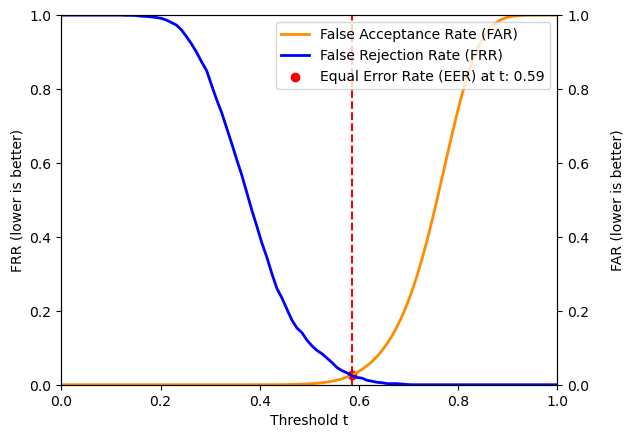

In [54]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

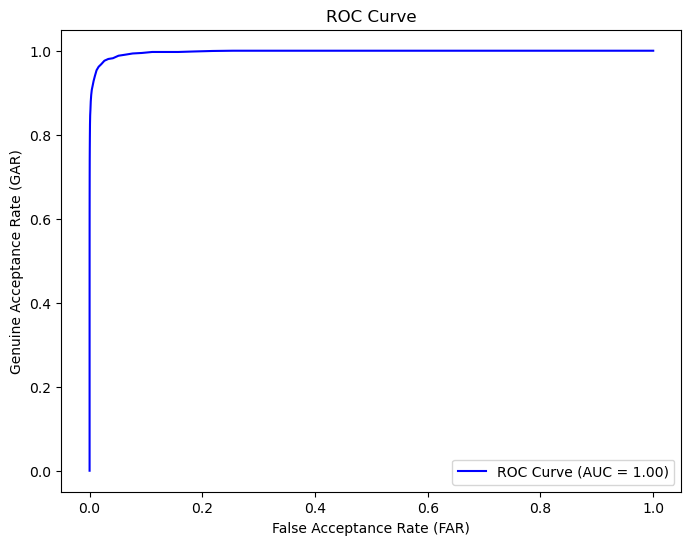

In [55]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

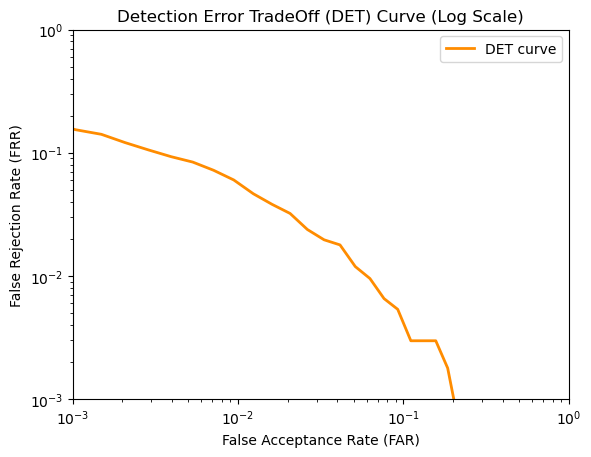

In [56]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on VGGFace2) and Evaluation on LFW (S=3 templates per subject)

In [41]:
# Select identities with exactly 3 image templates per subject (S=3) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 3)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([2703])
torch.Size([2703])
torch.Size([2703, 512])


In [43]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([    6,     7,     5,  ..., 13227, 13224, 13226], device='cuda:0')
tensor([   5,    5,    5,  ..., 5743, 5743, 5743], device='cuda:0')
tensor([[-0.0527, -0.0116,  0.0501,  ...,  0.0553,  0.0399, -0.0113],
        [-0.0214,  0.0180,  0.0144,  ...,  0.0452,  0.0285, -0.0482],
        [-0.0346,  0.0049,  0.0205,  ...,  0.0301,  0.0277, -0.0021],
        ...,
        [ 0.0638, -0.0160,  0.0102,  ..., -0.0107, -0.0174,  0.0151],
        [ 0.0189, -0.0008,  0.0244,  ..., -0.0427,  0.0067,  0.0401],
        [ 0.0076, -0.0091, -0.0015,  ..., -0.0360,  0.0107,  0.0199]],
       device='cuda:0')


In [46]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 3)

In [47]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 901
The total number of genuine attempts is: 5406
The total number of impostor attempts is: 7298100


In [48]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [49]:
normalized_matrix.size()

torch.Size([2703, 2703])

In [50]:
normalized_matrix

tensor([[0.0000e+00, 3.2688e-01, 2.9705e-01,  ..., 5.5098e-01, 6.0670e-01,
         6.6038e-01],
        [3.2688e-01, 5.0254e-04, 3.6533e-01,  ..., 6.2490e-01, 6.5503e-01,
         6.7815e-01],
        [2.9705e-01, 3.6533e-01, 2.6862e-04,  ..., 5.2348e-01, 6.3344e-01,
         6.4002e-01],
        ...,
        [5.5098e-01, 6.2490e-01, 5.2348e-01,  ..., 0.0000e+00, 3.6331e-01,
         4.0713e-01],
        [6.0670e-01, 6.5503e-01, 6.3344e-01,  ..., 3.6331e-01, 1.8994e-04,
         3.1523e-01],
        [6.6038e-01, 6.7815e-01, 6.4002e-01,  ..., 4.0713e-01, 3.1523e-01,
         0.0000e+00]], device='cuda:0')

In [51]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [53]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.001 | 0.000 | 0.999 | 1.000
0.15      | 0.001 | 0.000 | 0.999 | 1.000
0.16      | 0.001 | 0.000 | 0.999 | 1.000
0.17      | 0.001 | 0.000 | 0.999 | 1.000
0.18      | 0.003 | 0.000 | 0.997 | 1.000
0.19      | 0.005 | 0.000 | 0.995 | 1.000
0.20      | 0.008 | 0.000 | 0.992 | 1.000
0.21      

In [54]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

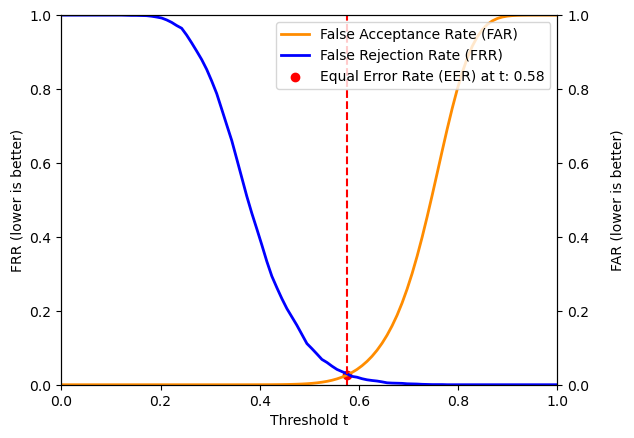

In [55]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

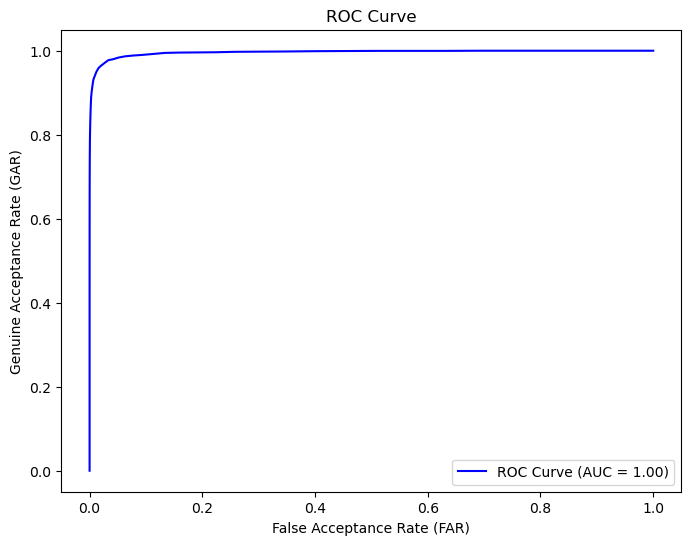

In [56]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

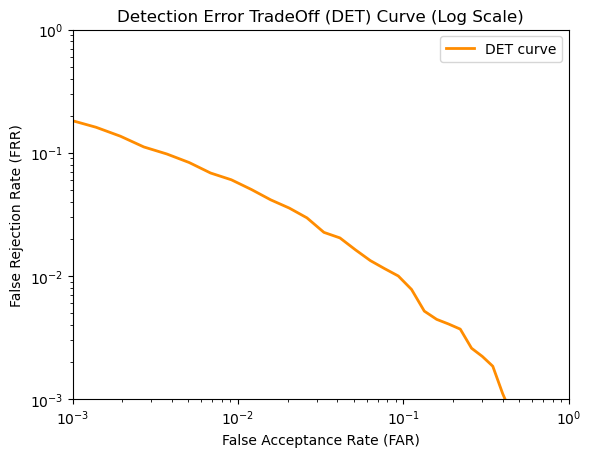

In [57]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on VGGFace2) and Evaluation on LFW (S=9 templates per subject)

In [41]:
# Select identities with exactly 9 image templates per subject (S=9) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 9)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([1656])
torch.Size([1656])
torch.Size([1656, 512])


In [45]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([   35,    38,    37,  ..., 13207, 13212, 13210], device='cuda:0')
tensor([  20,   20,   20,  ..., 5738, 5738, 5738], device='cuda:0')
tensor([[ 0.0215, -0.0364,  0.0423,  ...,  0.0379, -0.0417, -0.0267],
        [-0.0037,  0.0020,  0.0414,  ..., -0.0012, -0.0485,  0.0284],
        [ 0.0257,  0.0094,  0.0341,  ..., -0.0131, -0.0546, -0.0165],
        ...,
        [ 0.0894, -0.0226,  0.0137,  ..., -0.0142, -0.0645, -0.0135],
        [ 0.0988, -0.0323, -0.0222,  ...,  0.0103, -0.0405, -0.0240],
        [ 0.0626, -0.0537, -0.0282,  ..., -0.0171, -0.0590, -0.0370]],
       device='cuda:0')


In [46]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 9)

In [47]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 184
The total number of genuine attempts is: 13248
The total number of impostor attempts is: 2727432


In [48]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [49]:
normalized_matrix.size()

torch.Size([1656, 1656])

In [50]:
normalized_matrix

tensor([[0.0000e+00, 4.3771e-01, 3.9939e-01,  ..., 7.0179e-01, 7.6187e-01,
         7.2362e-01],
        [4.3771e-01, 0.0000e+00, 2.9515e-01,  ..., 7.7357e-01, 8.1365e-01,
         7.9807e-01],
        [3.9939e-01, 2.9515e-01, 0.0000e+00,  ..., 7.1882e-01, 7.8487e-01,
         7.3747e-01],
        ...,
        [7.0179e-01, 7.7357e-01, 7.1882e-01,  ..., 3.8938e-04, 3.6034e-01,
         2.8601e-01],
        [7.6187e-01, 8.1365e-01, 7.8487e-01,  ..., 3.6034e-01, 0.0000e+00,
         2.8002e-01],
        [7.2362e-01, 7.9807e-01, 7.3747e-01,  ..., 2.8601e-01, 2.8002e-01,
         0.0000e+00]], device='cuda:0')

In [51]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [52]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.001 | 0.000 | 0.999 | 1.000
0.16      | 0.001 | 0.000 | 0.999 | 1.000
0.17      | 0.001 | 0.000 | 0.999 | 1.000
0.18      | 0.002 | 0.000 | 0.998 | 1.000
0.19      | 0.003 | 0.000 | 0.997 | 1.000
0.20      | 0.005 | 0.000 | 0.995 | 1.000
0.21      

In [53]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

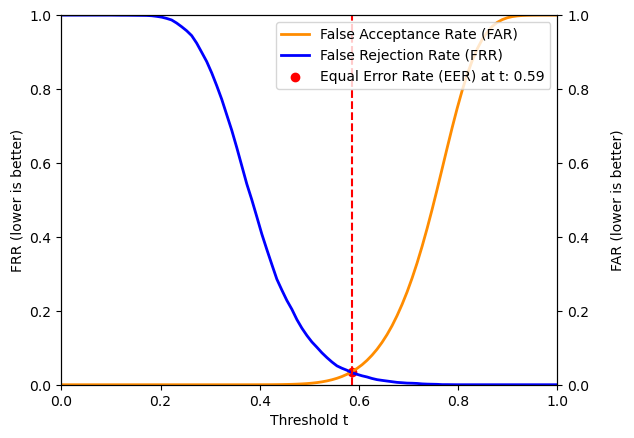

In [54]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

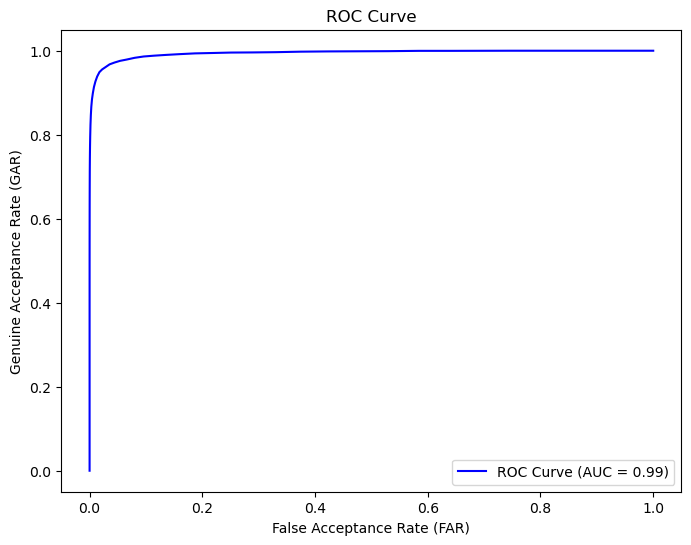

In [55]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

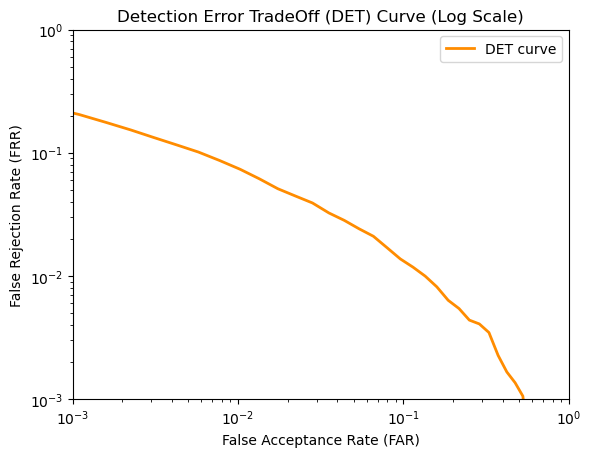

In [56]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on VGGFace2) and Evaluation on LFW (S=70 templates per subject)

In [41]:
# Select identities with exactly 70 image templates per subject (S=70) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 70)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([490])
torch.Size([490])
torch.Size([490, 512])


In [43]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([  849,   844,   835,   855,   846,   831,   857,   870,   879,   824,
          838,   816,   830,   834,   866,   817,   837,   859,   887,   863,
          892,   847,   826,   885,   820,   856,   836,   876,   825,   854,
          884,   842,   839,   886,   828,   853,   850,   891,   841,   852,
          875,   889,   848,   823,   867,   862,   871,   821,   874,   861,
          882,   832,   878,   860,   865,   840,   877,   858,   888,   872,
          864,   845,   851,   827,   880,   868,   819,   822,   873,   829,
         2376,  2242,  2379,  2330,  2341,  2219,  2228,  2207,  2395,  2226,
         2316,  2197,  2229,  2350,  2240,  2314,  2238,  2423,  2271,  2287,
         2284,  2230,  2309,  2270,  2372,  2344,  2345,  2223,  2324,  2265,
         2400,  2263,  2327,  2319,  2416,  2291,  2215,  2306,  2300,  2246,
         2411,  2394,  2419,  2235,  2424,  2340,  2360,  2199,  2383,  2217,
         2209,  2255,  2216,  2213,  2252,  2369,  2322,  2414, 

In [46]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 70)

In [47]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 7
The total number of genuine attempts is: 33810
The total number of impostor attempts is: 205800


In [48]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [49]:
normalized_matrix.size()

torch.Size([490, 490])

In [50]:
normalized_matrix

tensor([[3.6405e-04, 3.6955e-01, 4.2916e-01,  ..., 8.4915e-01, 7.9821e-01,
         8.3948e-01],
        [3.6955e-01, 0.0000e+00, 4.3522e-01,  ..., 7.6191e-01, 7.1718e-01,
         7.5947e-01],
        [4.2916e-01, 4.3522e-01, 0.0000e+00,  ..., 8.8672e-01, 8.6100e-01,
         9.5215e-01],
        ...,
        [8.4915e-01, 7.6191e-01, 8.8672e-01,  ..., 0.0000e+00, 4.9658e-01,
         4.1912e-01],
        [7.9821e-01, 7.1718e-01, 8.6100e-01,  ..., 4.9658e-01, 0.0000e+00,
         4.6976e-01],
        [8.3948e-01, 7.5947e-01, 9.5215e-01,  ..., 4.1912e-01, 4.6976e-01,
         3.6405e-04]], device='cuda:0')

In [51]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [52]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.000 | 0.000 | 1.000 | 1.000
0.16      | 0.000 | 0.000 | 1.000 | 1.000
0.17      | 0.000 | 0.000 | 1.000 | 1.000
0.18      | 0.000 | 0.000 | 1.000 | 1.000
0.19      | 0.001 | 0.000 | 0.999 | 1.000
0.20      | 0.001 | 0.000 | 0.999 | 1.000
0.21      

In [53]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

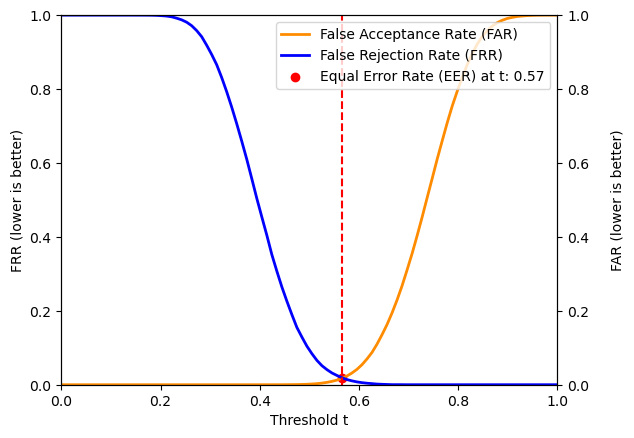

In [54]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

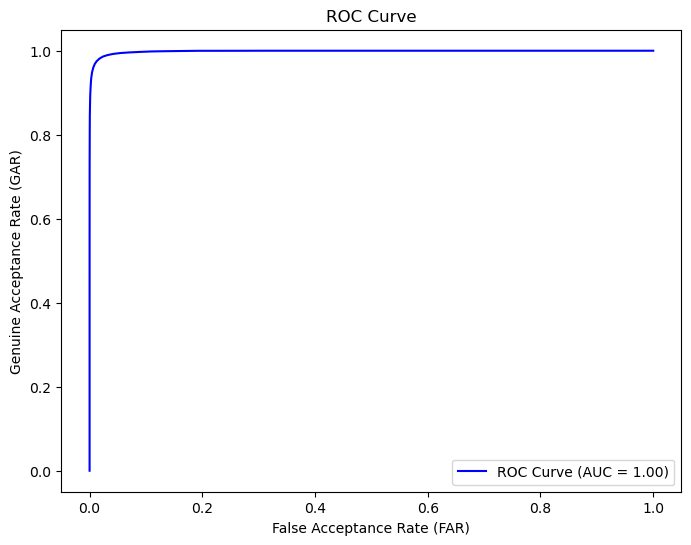

In [55]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

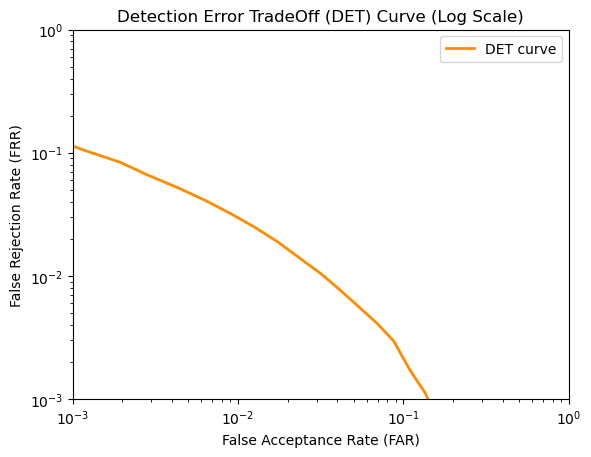

In [56]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on CASIA-Webface) and Evaluation on LFW (S=2 templates per subject)

In [33]:
# Load the pre-trained InceptionResnetV1 model (trained on CASIA-Webface)
resnet = load_model('casia-webface', device)

In [34]:
summary(resnet, input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-4                       9,216
|    └─BatchNorm2d: 2-5                  64
|    └─ReLU: 2-6                         --
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-7                       18,432
|    └─BatchNorm2d: 2-8                  128
|    └─ReLU: 2-9                         --
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-10                      5,120
|    └─BatchNorm2d: 2-11                 160
|    └─ReLU: 2-12                        --
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-13                      138,240
|    └─BatchNorm2d: 2-14                 384
|    └─ReLU: 2-15                        --
├─BasicC

In [35]:
# Create labels and embeddings for the images in the dataset using the loaded model
labels, embeddings = create_labels_and_embeddings(resnet, embed_loader, device)

In [36]:
embeddings

tensor([[-0.0416,  0.0821,  0.1224,  ...,  0.0773, -0.0171, -0.0951],
        [-0.1004,  0.0041,  0.1117,  ...,  0.0614, -0.0832, -0.1435],
        [-0.0239,  0.0741,  0.0611,  ...,  0.1100, -0.0179, -0.1095],
        ...,
        [ 0.0086,  0.0234,  0.0108,  ...,  0.0104,  0.0070, -0.0104],
        [ 0.0022,  0.0058,  0.0088,  ...,  0.0535, -0.0231, -0.0585],
        [-0.0149,  0.0227,  0.0066,  ...,  0.0227, -0.0319, -0.0526]],
       device='cuda:0')

In [37]:
labels.size()

torch.Size([13233])

In [40]:
embeddings.size()

torch.Size([13233, 512])

In [41]:
# Select identities with exactly 2 image templates per subject (S=2) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 2)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([3360])
torch.Size([3360])
torch.Size([3360, 512])


In [43]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([    6,     5,    11,  ..., 13219, 13226, 13227], device='cuda:0')
tensor([   5,    5,    7,  ..., 5740, 5743, 5743], device='cuda:0')
tensor([[-0.0685, -0.0048,  0.0274,  ...,  0.0876, -0.0175, -0.1121],
        [-0.0776,  0.0318,  0.0559,  ...,  0.0776, -0.0275, -0.1450],
        [-0.0362,  0.0204,  0.0776,  ...,  0.0622, -0.0424, -0.0784],
        ...,
        [-0.0109,  0.0382,  0.0210,  ...,  0.0591,  0.0108, -0.0636],
        [-0.0660,  0.0447,  0.0397,  ...,  0.1035, -0.0153, -0.1051],
        [-0.0704, -0.0290, -0.0201,  ...,  0.0290, -0.0203, -0.0734]],
       device='cuda:0')


In [44]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 2)

In [45]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 1680
The total number of genuine attempts is: 3360
The total number of impostor attempts is: 11282880


In [46]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [47]:
normalized_matrix.size()

torch.Size([3360, 3360])

In [48]:
normalized_matrix

tensor([[0.0000e+00, 3.4468e-01, 5.8990e-01,  ..., 5.7346e-01, 5.0700e-01,
         6.0451e-01],
        [3.4468e-01, 0.0000e+00, 5.8720e-01,  ..., 5.4512e-01, 4.5704e-01,
         5.6695e-01],
        [5.8990e-01, 5.8720e-01, 0.0000e+00,  ..., 5.6582e-01, 5.7263e-01,
         6.8196e-01],
        ...,
        [5.7346e-01, 5.4512e-01, 5.6582e-01,  ..., 2.9128e-04, 5.7987e-01,
         4.7760e-01],
        [5.0700e-01, 4.5704e-01, 5.7263e-01,  ..., 5.7987e-01, 0.0000e+00,
         5.3293e-01],
        [6.0451e-01, 5.6695e-01, 6.8196e-01,  ..., 4.7760e-01, 5.3293e-01,
         0.0000e+00]], device='cuda:0')

In [49]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [50]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.000 | 0.000 | 1.000 | 1.000
0.16      | 0.000 | 0.000 | 1.000 | 1.000
0.17      | 0.000 | 0.000 | 1.000 | 1.000
0.18      | 0.000 | 0.000 | 1.000 | 1.000
0.19      | 0.000 | 0.000 | 1.000 | 1.000
0.20      | 0.001 | 0.000 | 0.999 | 1.000
0.21      

In [51]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

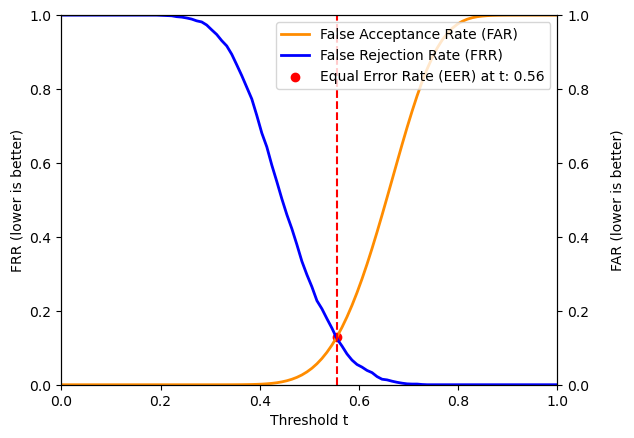

In [52]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

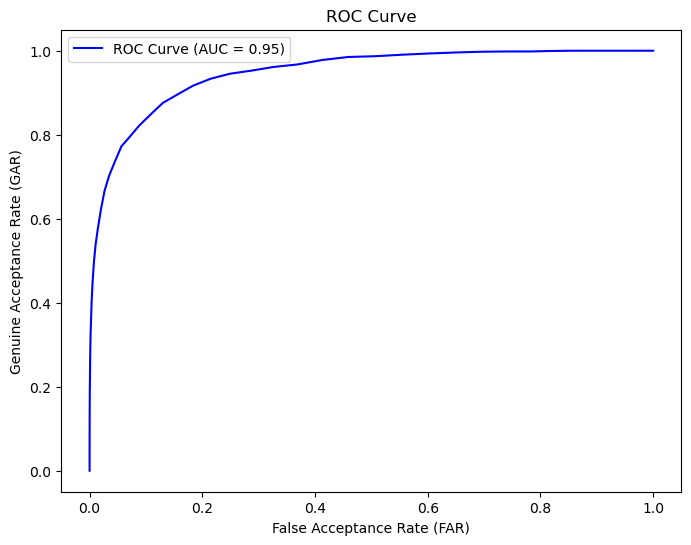

In [53]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

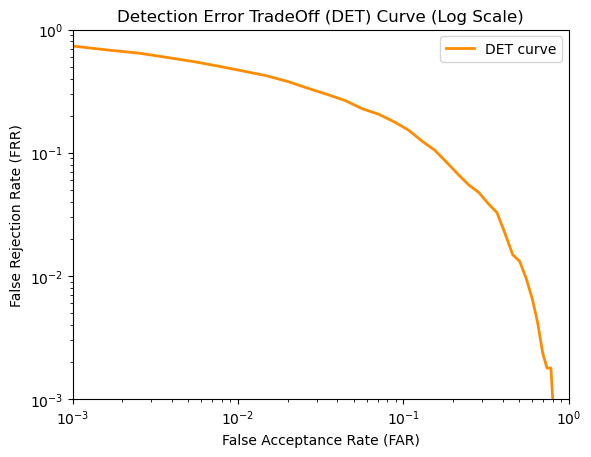

In [54]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on CASIA-Webface) and Evaluation on LFW (S=3 templates per subject)

In [63]:
# Select identities with exactly 3 image templates per subject (S=3) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 3)

In [64]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([2703])
torch.Size([2703])
torch.Size([2703, 512])


In [65]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([    7,     5,     6,  ..., 13224, 13226, 13225], device='cuda:0')
tensor([   5,    5,    5,  ..., 5743, 5743, 5743], device='cuda:0')
tensor([[-0.1007,  0.0004,  0.0432,  ...,  0.0582, -0.0833, -0.0743],
        [-0.0776,  0.0318,  0.0559,  ...,  0.0776, -0.0275, -0.1450],
        [-0.0685, -0.0048,  0.0274,  ...,  0.0876, -0.0175, -0.1121],
        ...,
        [-0.0844, -0.0196,  0.0498,  ...,  0.0904, -0.0332, -0.0332],
        [-0.0660,  0.0447,  0.0397,  ...,  0.1035, -0.0153, -0.1051],
        [-0.1175, -0.0230,  0.0287,  ...,  0.0633, -0.0395, -0.0418]],
       device='cuda:0')


In [66]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 3)

In [67]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 901
The total number of genuine attempts is: 5406
The total number of impostor attempts is: 7298100


In [68]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [69]:
normalized_matrix.size()

torch.Size([2703, 2703])

In [70]:
normalized_matrix

tensor([[4.2734e-04, 4.0334e-01, 4.4492e-01,  ..., 6.1377e-01, 6.1301e-01,
         5.7772e-01],
        [4.0334e-01, 0.0000e+00, 3.5757e-01,  ..., 6.3054e-01, 4.7413e-01,
         5.8687e-01],
        [4.4492e-01, 3.5757e-01, 0.0000e+00,  ..., 6.0100e-01, 5.2595e-01,
         5.9537e-01],
        ...,
        [6.1377e-01, 6.3054e-01, 6.0100e-01,  ..., 6.4100e-04, 5.1180e-01,
         3.2337e-01],
        [6.1301e-01, 4.7413e-01, 5.2595e-01,  ..., 5.1180e-01, 0.0000e+00,
         4.6477e-01],
        [5.7772e-01, 5.8687e-01, 5.9537e-01,  ..., 3.2337e-01, 4.6477e-01,
         0.0000e+00]], device='cuda:0')

In [71]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [72]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.000 | 0.000 | 1.000 | 1.000
0.16      | 0.000 | 0.000 | 1.000 | 1.000
0.17      | 0.000 | 0.000 | 1.000 | 1.000
0.18      | 0.000 | 0.000 | 1.000 | 1.000
0.19      | 0.000 | 0.000 | 1.000 | 1.000
0.20      | 0.001 | 0.000 | 0.999 | 1.000
0.21      

In [73]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

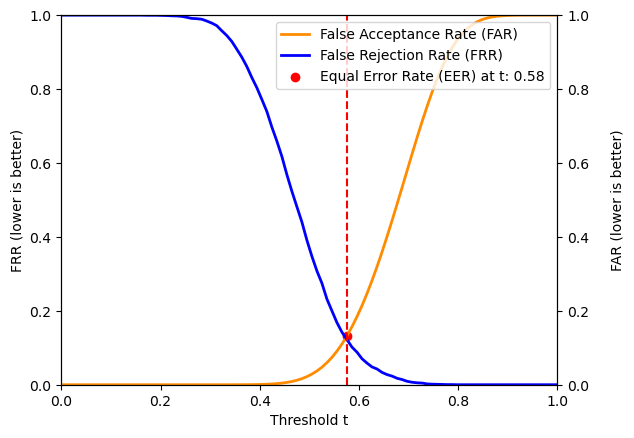

In [74]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

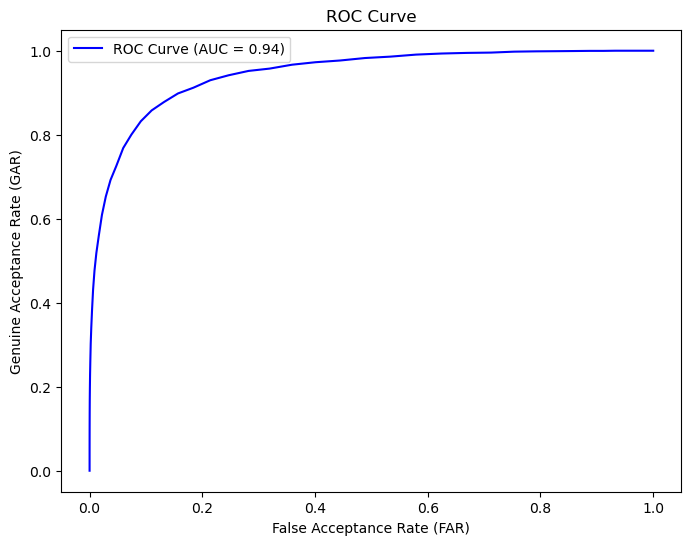

In [75]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

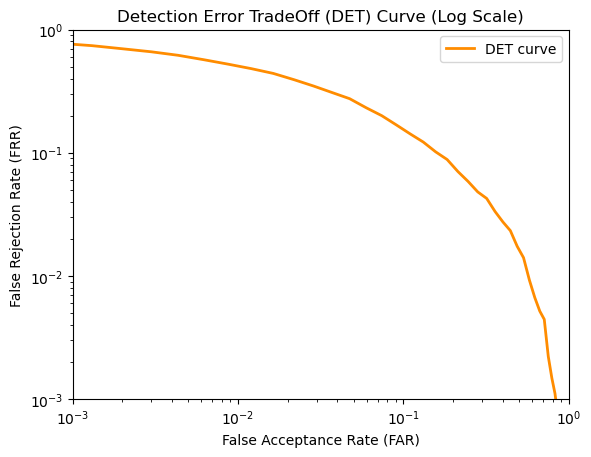

In [76]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on CASIA-Webface) and Evaluation on LFW (S=9 templates per subject)

In [42]:
# Select identities with exactly 9 image templates per subject (S=9) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 9)

In [43]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([1656])
torch.Size([1656])
torch.Size([1656, 512])


In [44]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([   41,    46,    40,  ..., 13208, 13209, 13207], device='cuda:0')
tensor([  20,   20,   20,  ..., 5738, 5738, 5738], device='cuda:0')
tensor([[-0.0095,  0.0428,  0.0328,  ...,  0.0563,  0.0037, -0.0584],
        [-0.0276,  0.0124,  0.0953,  ...,  0.0651,  0.0030, -0.0452],
        [-0.0333,  0.0115,  0.0973,  ...,  0.0860,  0.0215, -0.0723],
        ...,
        [ 0.0092,  0.0474,  0.0547,  ...,  0.0055,  0.0215, -0.0781],
        [-0.0046,  0.0524,  0.0596,  ...,  0.0063,  0.0323, -0.0907],
        [ 0.0026,  0.0421,  0.0717,  ...,  0.0159,  0.0173, -0.0958]],
       device='cuda:0')


In [45]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 9)

In [46]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 184
The total number of genuine attempts is: 13248
The total number of impostor attempts is: 2727432


In [47]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [48]:
normalized_matrix.size()

torch.Size([1656, 1656])

In [49]:
normalized_matrix

tensor([[0.0000e+00, 4.9320e-01, 5.2874e-01,  ..., 6.2476e-01, 6.3515e-01,
         6.1824e-01],
        [4.9320e-01, 5.4008e-04, 5.7998e-01,  ..., 5.9207e-01, 6.1528e-01,
         5.7071e-01],
        [5.2874e-01, 5.7998e-01, 0.0000e+00,  ..., 7.8938e-01, 7.5998e-01,
         7.4874e-01],
        ...,
        [6.2476e-01, 5.9207e-01, 7.8938e-01,  ..., 4.9302e-04, 2.1594e-01,
         3.1385e-01],
        [6.3515e-01, 6.1528e-01, 7.5998e-01,  ..., 2.1594e-01, 0.0000e+00,
         3.7572e-01],
        [6.1824e-01, 5.7071e-01, 7.4874e-01,  ..., 3.1385e-01, 3.7572e-01,
         3.8189e-04]], device='cuda:0')

In [50]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [51]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.000 | 0.000 | 1.000 | 1.000
0.16      | 0.000 | 0.000 | 1.000 | 1.000
0.17      | 0.000 | 0.000 | 1.000 | 1.000
0.18      | 0.000 | 0.000 | 1.000 | 1.000
0.19      | 0.000 | 0.000 | 1.000 | 1.000
0.20      | 0.000 | 0.000 | 1.000 | 1.000
0.21      

In [52]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

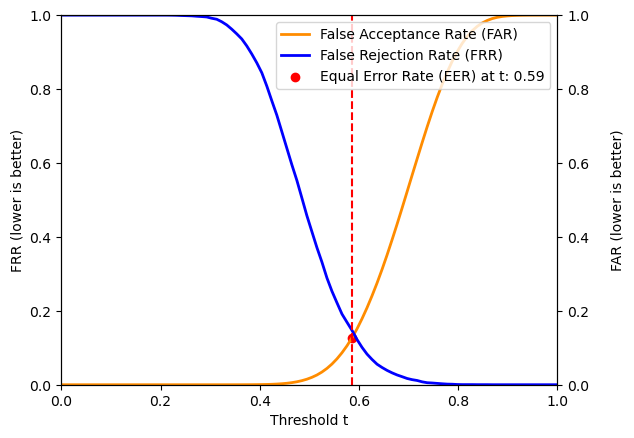

In [53]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

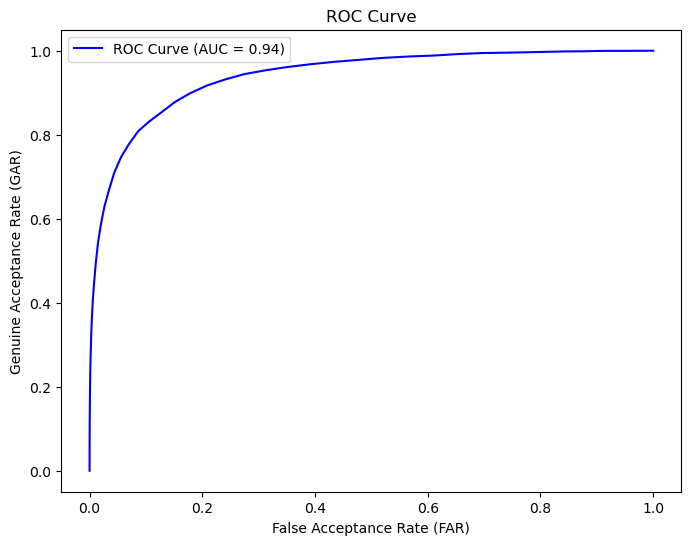

In [54]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

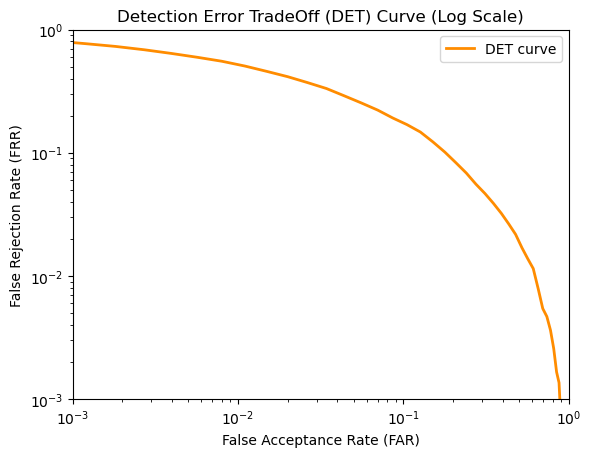

In [55]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)

## InceptionResnetV1 (pre-trained on CASIA-Webface) and Evaluation on LFW (S=70 templates per subject)

In [41]:
# Select identities with exactly 70 image templates per subject (S=70) from the dataset
selected_indices_tensor, selected_labels_tensor, selected_embeddings = select_identities_with_S_templates(labels, 70)

In [42]:
print(selected_indices_tensor.size())
print(selected_labels_tensor.size())
print(selected_embeddings.size())

torch.Size([490])
torch.Size([490])
torch.Size([490, 512])


In [43]:
print(selected_indices_tensor)
print(selected_labels_tensor)
print(selected_embeddings)

tensor([  853,   820,   847,   855,   836,   863,   890,   881,   834,   869,
          856,   819,   891,   844,   840,   845,   818,   817,   878,   860,
          877,   850,   849,   887,   828,   876,   889,   843,   821,   816,
          831,   858,   839,   852,   857,   854,   885,   848,   886,   825,
          827,   873,   829,   833,   846,   875,   874,   830,   824,   872,
          842,   868,   859,   880,   861,   823,   882,   888,   866,   892,
          826,   838,   884,   832,   862,   851,   871,   841,   883,   835,
         2279,  2243,  2224,  2314,  2220,  2203,  2194,  2381,  2249,  2353,
         2232,  2352,  2414,  2197,  2299,  2283,  2301,  2225,  2270,  2328,
         2326,  2365,  2228,  2251,  2322,  2341,  2417,  2215,  2291,  2253,
         2240,  2211,  2212,  2378,  2298,  2205,  2371,  2219,  2399,  2231,
         2360,  2409,  2309,  2325,  2286,  2262,  2426,  2330,  2308,  2388,
         2255,  2332,  2402,  2424,  2395,  2320,  2400,  2234, 

In [44]:
# Calculate the parameters for all-against-all comparison (N: number of subjects, TG: total genuine attempts, TI: total impostor attempts)
N, TG, TI = get_ALL_against_ALL_parameters(selected_labels_tensor, selected_embeddings, 70)

In [45]:
print("The number of subjects is:", N)
print("The total number of genuine attempts is:", TG)
print("The total number of impostor attempts is:", TI)

The number of subjects is: 7
The total number of genuine attempts is: 33810
The total number of impostor attempts is: 205800


In [46]:
# Create the distance matrix between embeddings using Euclidean distance
normalized_matrix = create_ALL_against_ALL_distance_matrix(selected_embeddings)

In [47]:
normalized_matrix.size()

torch.Size([490, 490])

In [48]:
normalized_matrix

tensor([[3.3048e-04, 5.3962e-01, 5.8477e-01,  ..., 7.6891e-01, 7.8753e-01,
         7.8450e-01],
        [5.3962e-01, 0.0000e+00, 3.7030e-01,  ..., 7.1505e-01, 5.8564e-01,
         6.2216e-01],
        [5.8477e-01, 3.7030e-01, 0.0000e+00,  ..., 7.0441e-01, 5.6897e-01,
         6.0086e-01],
        ...,
        [7.6891e-01, 7.1505e-01, 7.0441e-01,  ..., 4.0475e-04, 5.2223e-01,
         6.1923e-01],
        [7.8753e-01, 5.8564e-01, 5.6897e-01,  ..., 5.2223e-01, 3.3048e-04,
         3.8889e-01],
        [7.8450e-01, 6.2216e-01, 6.0086e-01,  ..., 6.1923e-01, 3.8889e-01,
         5.7240e-04]], device='cuda:0')

In [49]:
# Evaluate the system by calculating GAR, FAR, FRR, GRR at different thresholds
GAR, FAR, FRR, GRR, GA, FA, FR, GR, thresholds = evaluate_ALL_against_ALL_distance_matrix(normalized_matrix, selected_labels_tensor, TG, TI)

In [50]:
print_metrics(GAR, FAR, FRR, GRR, thresholds)

Threshold (t)  | GAR(t)   | FAR(t)   | FRR(t)   | GRR(t)
--------------------------------------------------
0.00      | 0.000 | 0.000 | 1.000 | 1.000
0.01      | 0.000 | 0.000 | 1.000 | 1.000
0.02      | 0.000 | 0.000 | 1.000 | 1.000
0.03      | 0.000 | 0.000 | 1.000 | 1.000
0.04      | 0.000 | 0.000 | 1.000 | 1.000
0.05      | 0.000 | 0.000 | 1.000 | 1.000
0.06      | 0.000 | 0.000 | 1.000 | 1.000
0.07      | 0.000 | 0.000 | 1.000 | 1.000
0.08      | 0.000 | 0.000 | 1.000 | 1.000
0.09      | 0.000 | 0.000 | 1.000 | 1.000
0.10      | 0.000 | 0.000 | 1.000 | 1.000
0.11      | 0.000 | 0.000 | 1.000 | 1.000
0.12      | 0.000 | 0.000 | 1.000 | 1.000
0.13      | 0.000 | 0.000 | 1.000 | 1.000
0.14      | 0.000 | 0.000 | 1.000 | 1.000
0.15      | 0.000 | 0.000 | 1.000 | 1.000
0.16      | 0.000 | 0.000 | 1.000 | 1.000
0.17      | 0.000 | 0.000 | 1.000 | 1.000
0.18      | 0.000 | 0.000 | 1.000 | 1.000
0.19      | 0.000 | 0.000 | 1.000 | 1.000
0.20      | 0.000 | 0.000 | 1.000 | 1.000
0.21      

In [51]:
# Convert PyTorch tensors to NumPy for visualization
thresholds_np = thresholds.cpu().numpy()
FARs = FAR.cpu().numpy()
FRRs = FRR.cpu().numpy()
GARs = GAR.cpu().numpy()
GRRs = GRR.cpu().numpy()

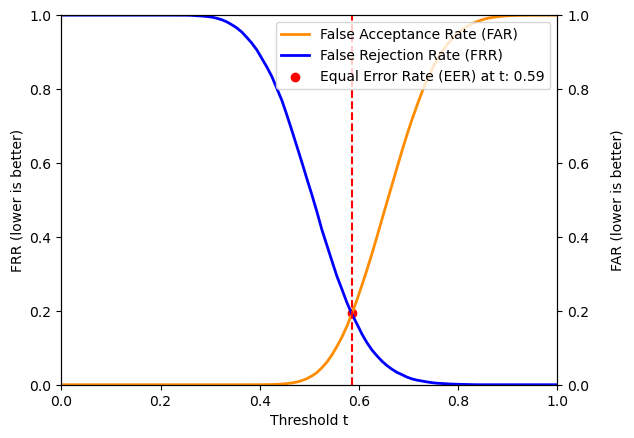

In [52]:
# Plot the EER (Equal Error Rate), which indicates the threshold where FAR and FRR are equal
eer_index = plot_EER(FARs, FRRs, thresholds_np)

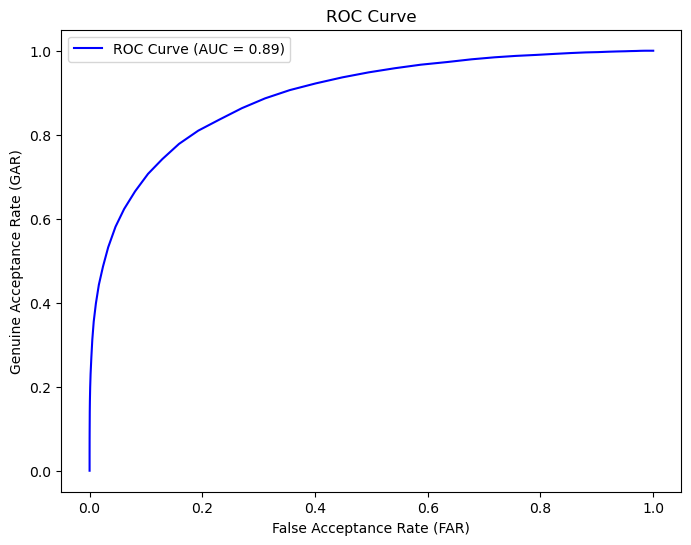

In [53]:
# Plot the ROC curve (Genuine Acceptance Rate vs. False Acceptance Rate)
plot_ROC(FARs, GARs)

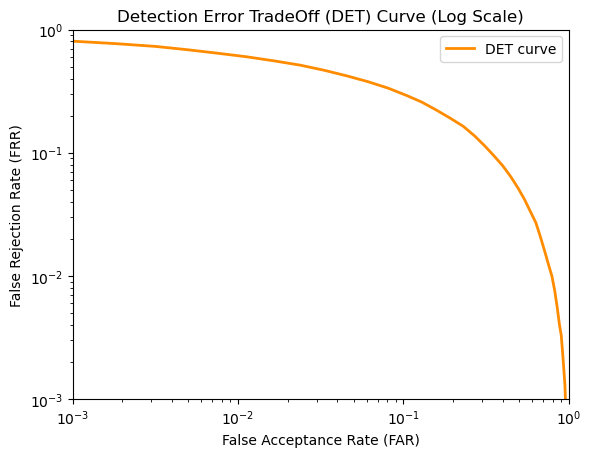

In [54]:
# Plot the DET curve (False Acceptance Rate vs. False Rejection Rate)
plot_DET(FARs, FRRs)